# Ensembles
Lecture recap
1. Combine many weak algorithms into one strong
2. Most of them use decision trees as base estimators - they are fast, invariant to scaling, and handle well features of different nature
3. For problems like the one about Higgs (small number of features of different origin) state-of-the is ensembles of decision trees.

## RandomForest
1. Uses random subspace method on Decision Trees
2. Isn't prone to overfitting
3. Easily parallelized

## Boosting
1. Ensemble members are trained consequently to compensate for imperfection
2. Will overfit, especially if strong base algorithms are used
3. Can be parallelized (Google is your friend)

## Bagging over KNN over Higgs data

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import root_pandas
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier

In [10]:
high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']
training_data = root_pandas.read_root(
    "/notebooks/public_train_10000.root", columns=high_level_features + ["target",])

First, we try KNN on massses - from the baseline we know those are good features.

In [11]:
knn_cv = cross_val_score(KNeighborsClassifier(),
                training_data[high_level_features],
                training_data["target"],
                cv=4, n_jobs=4, scoring="roc_auc")
print knn_cv.mean(), knn_cv.std()

0.705906863774 0.00224599292916


Then we try bagging over it.

In [12]:
bagging_cv = cross_val_score(BaggingClassifier(base_estimator=KNeighborsClassifier(), n_jobs=4),
                             training_data[high_level_features],
                             training_data["target"], scoring='roc_auc', cv=4)
print bagging_cv.mean(), bagging_cv.std()

0.711610590783 0.00427209987847


Free prediction power improvement this is.

# RandomForest
Let's see how decision surface for ReandomForest changes with incerase in the number of estimators.

/root/miniconda/envs/rep_py2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


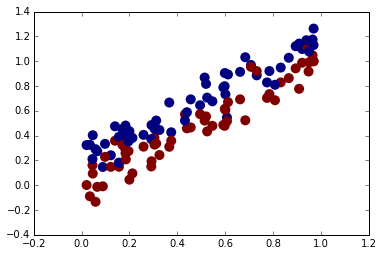

In [13]:
np.random.seed(42)
x_space = np.random.uniform(0, 1, size=60)
y0 = x_space + 0.2 + np.random.normal(size=len(x_space), scale=0.1)
y1 = x_space + np.random.normal(size=len(x_space), scale=0.1)
shuffle = np.random.permutation(2*len(x_space))
line_features = np.concatenate((np.concatenate((x_space, x_space))[:, np.newaxis],
                          np.concatenate((y0, y1))[:, np.newaxis]), axis=1)[shuffle]
line_labels = np.concatenate((np.zeros(len(y0)), np.ones(len(y1))))[shuffle]
fig, ax = plt.subplots()
ax.scatter(line_features[:, 0], line_features[:, 1], c=line_labels, edgecolors='none', s=100)

In [14]:
n_classes = 2
plot_colors = "bry"
plot_step = 0.02
from sklearn.preprocessing import scale
def plot_decision_on_axes(clf, ax, features, labels):
    X = scale(features)
    X = features
    clf.fit(X, labels)
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.axis("tight")

    # Plot the training points
    for i, color in zip(range(n_classes), plot_colors):
        idx = np.where(labels == i)
        ax.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)

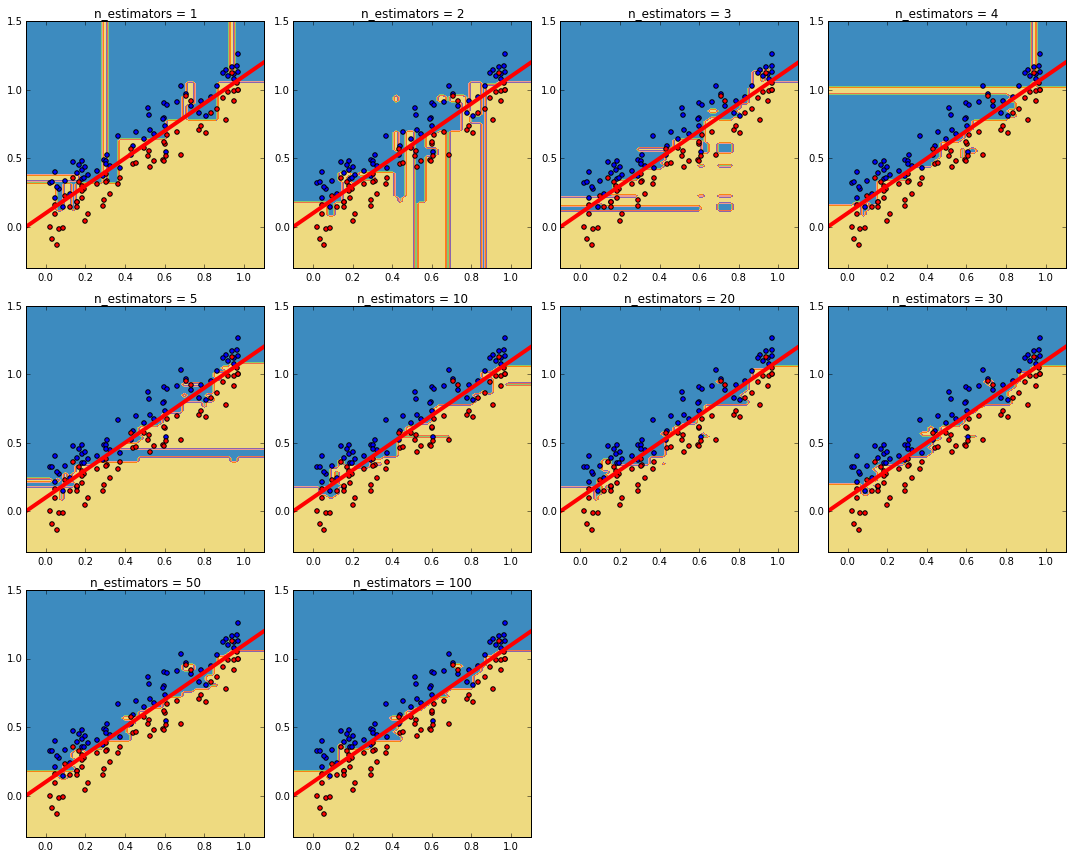

In [15]:
from sklearn.ensemble import RandomForestClassifier
estimators_set = (1, 2, 3, 4, 5, 10, 20, 30, 50, 100)
screen_width, plot_height = 15, 4
n_rows = 3
n_cols = np.ceil(np.true_divide(len(estimators_set), n_rows))
fig = plt.figure(figsize=(screen_width, plot_height*n_rows))
x_range = np.linspace(-0.1, 1.1, num=100)
y_true = x_range + 0.1
for i, n_estimators in enumerate(estimators_set):
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators)
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    plot_decision_on_axes(clf, ax, line_features, line_labels)
    ax.set_title("n_estimators = %d" % n_estimators)
    ax.plot(x_range, y_true, 'r', lw=4)
    ax.set_xlim((-0.1, 1.1))
    ax.set_ylim((-0.3, 1.5))
plt.tight_layout()

## Boosting for Higgs data

In [16]:
from rep.estimators import XGBoostClassifier # Use wrapper from Yandex REP by Alexey and Tatiana

In [17]:
# XGBoostClassifier is parrallel inside
xgboost_cv = cross_val_score(XGBoostClassifier(),
                             training_data[high_level_features].astype(np.float64),
                             training_data["target"].astype(np.int64), cv=4, scoring="roc_auc")
print(xgboost_cv.mean(), xgboost_cv.std())

(0.73241052460080436, 0.0097633293951946004)


What if try on all features?

In [18]:
training_data_all_columns = root_pandas.read_root("/notebooks/public_train_10000.root").astype(np.float64)

In [19]:
features_all_columns = training_data_all_columns[list(set(training_data_all_columns ) - {"target", "event_id"})]
target_all_columns = training_data_all_columns.target.astype(np.bool)

In [20]:
knn_cv_on_full = cross_val_score(KNeighborsClassifier(), features_all_columns, target_all_columns, cv=4, n_jobs=4,
                                scoring="roc_auc")
print(knn_cv_on_full.mean(), knn_cv_on_full.std())

(0.70057958450276958, 0.0046992025048028935)


KNN Didn't improve.

What if we change metric in KNN to canberra?
Was:
$$
d(p,q) = \sqrt{\sum_{i=1}^n(|p_i - q_i|^2)}
$$

Became:
$$
d(p,q) = \sum_{i=1}^n\frac{p_i-q_i}{|p_i|+|q_i|}
$$

In [21]:
knn_cv_canberra = cross_val_score(KNeighborsClassifier(metric="canberra"),
                                  features_all_columns, target_all_columns, cv=4, n_jobs=4, scoring="roc_auc")
print(knn_cv_canberra.mean(), knn_cv_canberra.std())

(0.57357673032177203, 0.0040452774943448037)


Have any ideas why normalization went wrong?

In [22]:
xgb_cv_full = cross_val_score(XGBoostClassifier(), features_all_columns, target_all_columns, cv=4,
                              scoring="roc_auc")
print(xgb_cv_full.mean(), xgb_cv_full.std())

(0.73784270957800213, 0.0030414122354386207)


A tiny bit better than XGB only on the high level features, but still worse than KNN. 

AdaBoost over XGBoost. _May quite take some time to run._

In [23]:
from sklearn.ensemble import AdaBoostClassifier

In [25]:
ada_on_xgb = cross_val_score(AdaBoostClassifier(base_estimator=XGBoostClassifier()),
                              features_all_columns, target_all_columns, cv=4, scoring="roc_auc")
print(ada_on_xgb.mean(), ada_on_xgb.std())

(0.74683250153620173, 0.0040148587402599944)


**Exercise 0** Plot learning curve for the KNN and XGBoost. On X axis there should be the training dataset size, on Y axis - cross-validation performance.

Learning curve is useful when selecting a dataset size for experimentation as execution time grows with the dataset size.
1. http://scikit-learn.org/stable/modules/generated/sklearn.learning_curve.validation_curve.html#sklearn.learning_curve.validation_curve
2. Bonus points for plotting errors, for example with http://matplotlib.org/api/axes_api.html#matplotlib.axes.Axes.fill_between

**Exercise 1** Beat ROC AUC score 0.75 by tuning XGBoost parameters. That's the normal procedure for solving ML problems, the methods to automate it would be discussed on Saturday.

**Exercise 2** Apply AdaBoost to the XGBoost with parameters above and submit the result to Kaggle.

**Exercise $\infty$** Win the Kaggle! A few suggestions to try:
 1. Use the learning curve to find the optimal dataset size for experimentation.
 2. Use multiple classifiers (possibly on different features) and average the predictions.
 3. Try generating new features using dimensionality reduction (possibly on groups of features of the same nature)
 4. Use GridSearch to select parameters. When using ensembles, you can separately optimize first the basic classifier parameters, then the enseble.